# EDA - 1
Guests Who Stay for Different Durations Prefer Certain Types of Geographical Locations and Surrounding Environments

In [38]:
!pip3 install statsmodels

     |████████████████████████████████| 9.5 MB 1.2 MB/s eta 0:00:01     |█████████████████████████▉      | 7.7 MB 1.5 MB/s eta 0:00:02
     |████████████████████████████████| 231 kB 406 kB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.


In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [163]:
df_raw = pd.read_csv('../Datasets/cleaned_customer.csv')
df_raw.head()

,reviewer_id,listing_id,date,reviewer_name,comments,name,description,neighborhood_overview,host_id,host_since,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,nearby_sites_rating,nearest_station_dist,nearest_site_dist,nearest_site_rating
0,8557223,49091,2013-10-21,Jared,Fran was absolutely gracious and welcoming. Ma...,COZICOMFORT LONG TERM STAY ROOM 2,This is Room No. 2.(available after Jan 15 201...,NaN,266763,2010-10-20,...,10.0,8.0,8.0,f,2,0.02,0.995731,0.617762,4.295315,4.595264
1,1356099,50646,2014-04-18,James,A comfortable room in a smart condo developmen...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,2010-09-08,...,10.0,9.0,9.0,f,1,0.30,1.269606,0.399696,2.039236,4.654423
2,15222393,50646,2014-06-05,Welli,Stayed over at Sujatha's house for 3 good nigh...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,2010-09-08,...,10.0,9.0,9.0,f,1,0.30,1.269606,0.399696,2.039236,4.654423
3,5543172,50646,2014-07-02,Cyril,It's been a lovely stay at Sujatha's. The room...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,2010-09-08,...,10.0,9.0,9.0,f,1,0.30,1.269606,0.399696,2.039236,4.654423
4,817532,50646,2014-07-08,Jake,"We had a great experience. A nice place, an am...",Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,2010-09-08,...,10.0,9.0,9.0,f,1,0.30,1.269606,0.399696,2.039236,4.654423


In [45]:
df_raw.columns

Index(['reviewer_id', 'listing_id', 'date', 'reviewer_name', 'comments',
       'name', 'description', 'neighborhood_overview', 'host_id', 'host_since',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores

In [165]:
# Extracts the reviews and relevant location data
df = df_raw[['listing_id','comments','review_scores_location','nearby_sites_rating','nearest_site_rating','nearest_site_dist','nearest_station_dist']]

In [166]:
df.drop_duplicates()

,listing_id,comments,review_scores_location,nearby_sites_rating,nearest_site_rating,nearest_site_dist,nearest_station_dist
0,49091,Fran was absolutely gracious and welcoming. Ma...,8.0,0.995731,4.595264,4.295315,0.617762
1,50646,A comfortable room in a smart condo developmen...,9.0,1.269606,4.654423,2.039236,0.399696
2,50646,Stayed over at Sujatha's house for 3 good nigh...,9.0,1.269606,4.654423,2.039236,0.399696
3,50646,It's been a lovely stay at Sujatha's. The room...,9.0,1.269606,4.654423,2.039236,0.399696
4,50646,"We had a great experience. A nice place, an am...",9.0,1.269606,4.654423,2.039236,0.399696
...,...,...,...,...,...,...,...
155245,46164107,Nice place to stay,9.0,1.812501,4.138595,0.919134,0.257987
155246,46164107,Convenient erea,9.0,1.812501,4.138595,0.919134,0.257987
155247,46164107,nice place,9.0,1.812501,4.138595,0.919134,0.257987
155248,46420476,-,7.0,1.428967,4.487300,1.923091,0.582080


In [92]:
!pip3 install afinn
from afinn import Afinn

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.


In [93]:
afinn = Afinn()
afinn_scores = [afinn.score(str(text)) for text in df.comments]

In [170]:
from sklearn.preprocessing import normalize
df['score'] = afinn_scores
df_uniq = df.drop(['comments'],axis=1).dropna()
df_uniq = df_uniq.groupby(['listing_id']).mean()

<ipython-input-170-7651e7a1b47f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = afinn_scores


In [177]:
df.comments[df.score > 30].sample(10)

84482     Highly recommended! Josh was a fantastic host,...
112676    Absolutely gem of a place - firstly Edwina is ...
97753     This place is very modest and tiny. It may be ...
19668     The room is so nice, beautiful, and is exactly...
113787    If you want to experience Singapore and the qu...
119568    This was our first time using Airbnb and we we...
19428     Pros:\n- very clean place\n- accurate descript...
136947    Condition\nHis place is great, Very tidy and l...
41179     We had a great stay in Wei's apartment & Singa...
2110      I am from Germany and stayed with Fendy about ...
Name: comments, dtype: object

In [219]:
def scatplot(df,x,y,size=0.1,min_y=0,max_y=1):
    df_sample = df.sample(int(df.shape[0]*size))   
    plt.scatter(df_sample.loc[:,x],df_sample.loc[:,y])
    plt.ylim(min_y*df_sample[y].min(),max_y*df_sample[y].max())

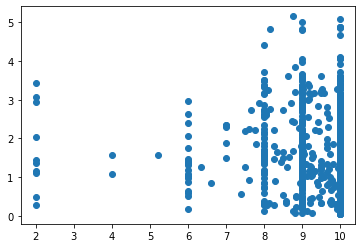

In [208]:
scatplot(df_uniq,'review_scores_location','nearest_site_dist')

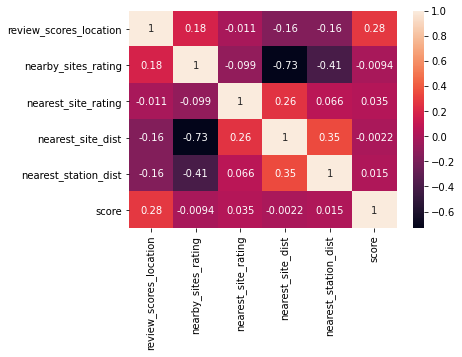

In [226]:
corrMatrix = df_uniq.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [172]:
def linear_model(X,y):
    import statsmodels.api as sm
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())
    print("R Squared:",est2.rsquared)

In [173]:
X = df_uniq[['review_scores_location','nearby_sites_rating','nearest_site_rating','nearest_site_dist','nearest_station_dist']]
y = df_uniq['score']
linear_model(X,y)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     154.5
Date:                Sat, 06 Mar 2021   Prob (F-statistic):          1.52e-157
Time:                        09:42:37   Log-Likelihood:                -24463.
No. Observations:                8465   AIC:                         4.894e+04
Df Residuals:                    8459   BIC:                         4.898e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -9

# EDA - 5

Convenience Plays the Most Important Role in Pricing Apartments

In [184]:
df_price = df_raw[['listing_id','price','review_scores_location','nearby_sites_rating','nearest_station_dist','nearest_site_rating','nearest_site_dist']].drop_duplicates().dropna()
df_price.price = df_price.price.apply(lambda x:float(x.strip('$').replace(',','')))
df_price_uniq = df_price.groupby(['listing_id']).mean().reset_index(drop=True)

In [185]:
df_price_uniq.head()

,price,review_scores_location,nearby_sites_rating,nearest_station_dist,nearest_site_rating,nearest_site_dist
0,81.0,8.00,0.995731,0.617762,4.595264,4.295315
1,80.0,9.00,1.269606,0.399696,4.654423,2.039236
2,68.0,8.00,0.995281,0.524353,4.595264,4.290337
3,202.5,8.25,1.116033,0.486745,4.456579,2.648653
4,93.0,8.00,1.113617,0.481193,4.456579,2.436100


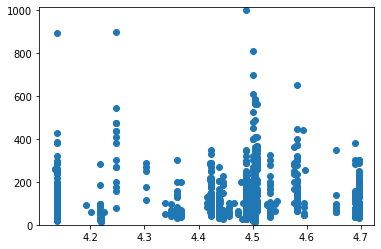

In [224]:
scatplot(df_price_uniq,'nearest_site_rating','price',max_y=0.4)

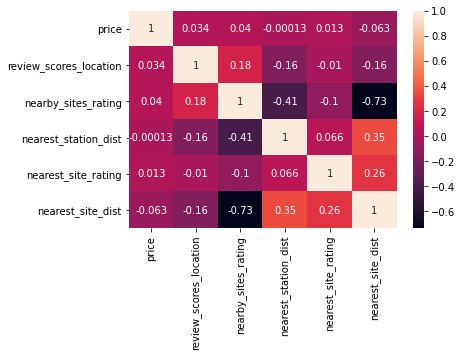

In [227]:
corrMatrix_p = df_price_uniq.corr()
sn.heatmap(corrMatrix_p, annot=True)
plt.show()

In [186]:
X = df_price_uniq[['review_scores_location','nearby_sites_rating','nearest_station_dist','nearest_site_rating','nearest_site_dist']]
y = df_price_uniq['price']
linear_model(X,y)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     10.66
Date:                Sat, 06 Mar 2021   Prob (F-statistic):           3.15e-10
Time:                        09:52:06   Log-Likelihood:                -57741.
No. Observations:                8465   AIC:                         1.155e+05
Df Residuals:                    8459   BIC:                         1.155e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -90